In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Pool
from itertools import product
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Import data


In [2]:
f='../data/'
test          = pd.read_csv(f+'test.csv.gz')
shop          = pd.read_csv(f+'shops.csv')
sample_submission    = pd.read_csv(f+'sample_submission.csv.gz')
sales         = pd.read_csv(f+'sales_train.csv.gz')
items         = pd.read_csv(f+'items.csv')
item_category = pd.read_csv(f+'item_categories.csv')

# Aggregate data
Since the test data is generated with combination of shops and items, we have to restructure train data to match the test data generation. 

In [3]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

#Compute all shops/items combinations
grid = []
for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
grid.sample(30)

,shop_id,item_id,date_block_num
10648078,31,8800,32
4376836,58,19070,11
2240010,53,12835,5
2401682,14,3007,6
5349972,35,19721,14
5588448,21,18005,15
9080492,34,278,26
3751291,27,11433,10
7826232,29,6051,22
2435377,3,14767,6


# Exploratory Data Analysis

There is 60 unique shop_id

In [4]:
shop.head(5)
shop.describe()
shop.shop_id.unique()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


,shop_id
count,60.000000
mean,29.500000
std,17.464249
min,0.000000
25%,14.750000
50%,29.500000
75%,44.250000
max,59.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)

There is 60 unique item_category_id.

In [5]:
item_category.head(5)
item_category.describe()
item_category.item_category_id.unique()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int64)

There is 22170 unique item_id.

In [6]:
items.loc[42].item_name

'100 Best romantic melodies (mp3-CD) (Digipack)'

In [7]:
items.head(5)
items.describe()
items.item_id.unique().shape[0]

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


22170

Review the format for submission.

In [8]:
test.head(5)
sample_submission.head(5)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


Finally, the main dataset for training data. 

In [9]:
sales.head(5)
sales.describe()
len(sales)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


2935849

# Plot of date_block_num against index. 

The distribution of each date_block_num is not balanced, there are some outliers

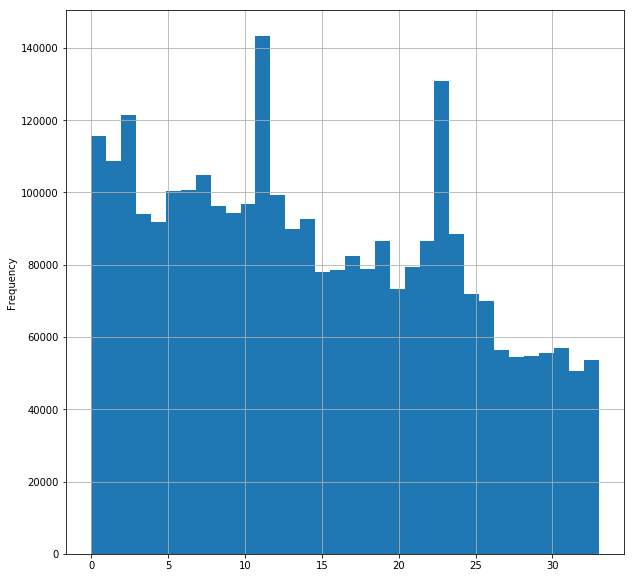

In [10]:
bins =(sales.date_block_num.unique()) 
sales.date_block_num.plot.hist(bins = len(bins),figsize = (10,10), grid = True)


['2013.01', '2013.02', '2013.03', '2013.04', '2013.05', '2013.06', '2013.07', '2013.08', '2013.09', '2013.10', '2013.11', '2013.12', '2014.01', '2014.02', '2014.03', '2014.04', '2014.05', '2014.06', '2014.07', '2014.08', '2014.09', '2014.10', '2014.11', '2014.12', '2015.01', '2015.02', '2015.03', '2015.04', '2015.05', '2015.06', '2015.07', '2015.08', '2015.09']


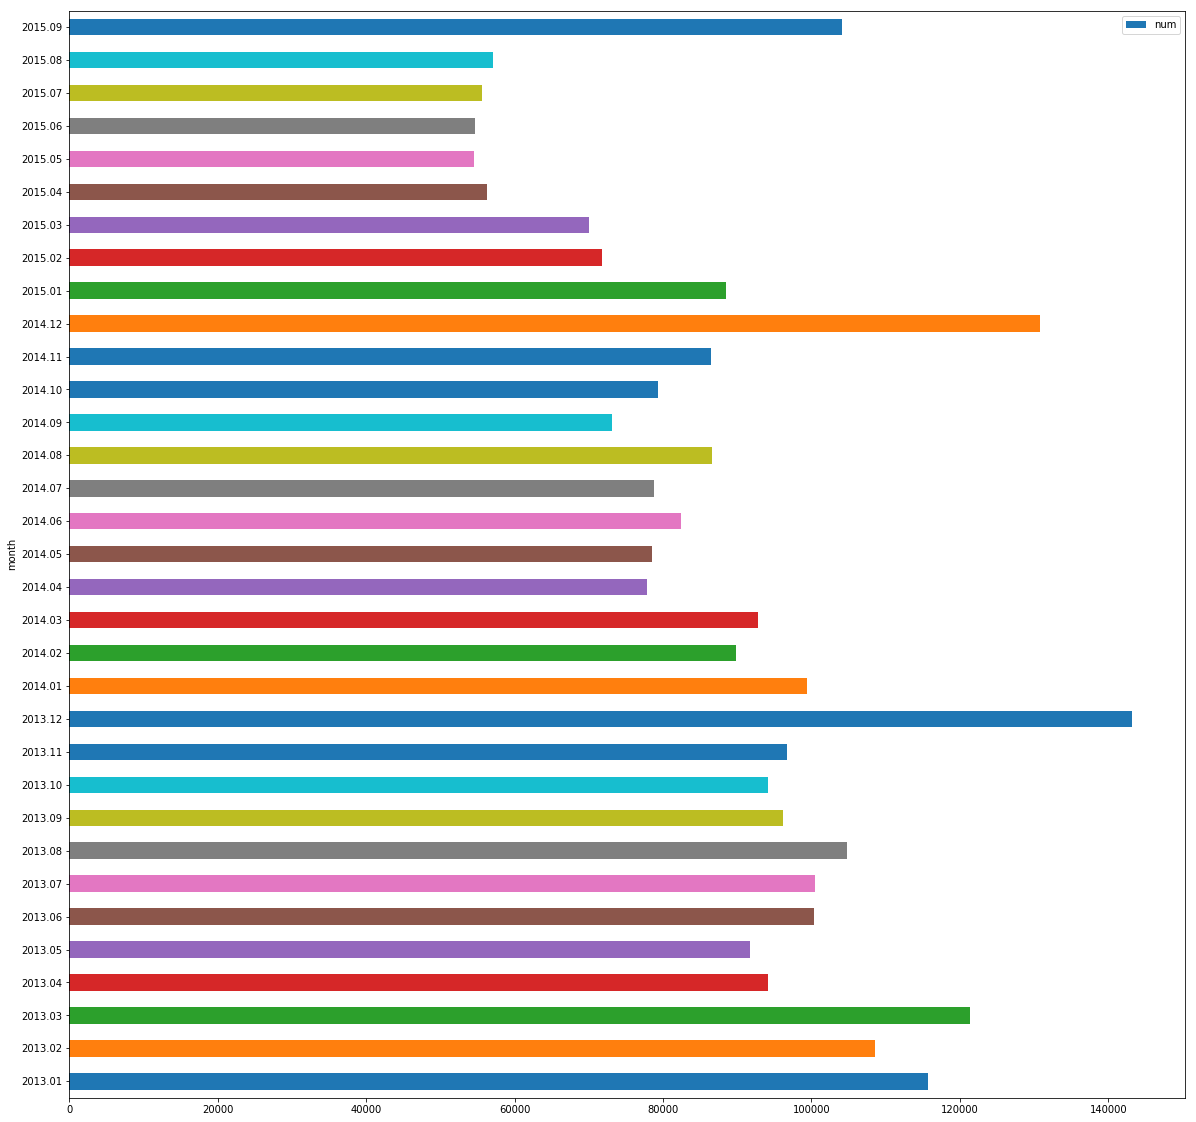

In [11]:
import calendar
date_block_labels = []
y_i,m_i = 2013,1
for i in range(33):
    y = y_i+ i//12
    m = m_i + np.mod(i,12)
    date_block_labels.append('%4d.%02d'%(y,m))
print(date_block_labels)

month_stat = pd.DataFrame( )
count, division = np.histogram(sales.date_block_num, bins=bins)


month_stat = pd.DataFrame(data={'month':date_block_labels, 'num':count})
month_stat.plot.barh(x='month', y='num', figsize=(20,20))

We can see peaks in December. It sounds reasonable

# Shops Leakage utilization

Shops geography aren't anonimized, so we can substact some information from the feature names

In [12]:
#This addresses are seems to be the same
for i in [10,11]:
    print(shop.loc[i].shop_name)
print('-'*20)
shop.at[10,'shop_name']=shop.loc[11,'shop_name']

#Remove ! sign from city name
shop.shop_name = shop.shop_name.apply(lambda x: x.replace('!',''))
   

# Group to e-shops into single category
print(shop.loc[55].shop_name)
print(shop.loc[12].shop_name)
shop.at[55,'shop_name']='Интернет-магазин '+shop.at[55,'shop_name']

display(shop)


Жуковский ул. Чкалова 39м?
Жуковский ул. Чкалова 39м²
--------------------
Цифровой склад 1С-Онлайн
Интернет-магазин ЧС


,shop_name,shop_id
0,"Якутск Орджоникидзе, 56 фран",0
1,"Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


Cut city name from the shop name, also normalize city name. Thanks God I'm Russian and can identify Russian cities by their acronyms :)

In [13]:
from sklearn.preprocessing import LabelEncoder
shop['shop_city'] = shop['shop_name'].str.split().str[0].str.strip()

# Parse results of city parser, normalize city names
replace_table=[
     ['РостовНаДону', 'Ростов-на-Дону',]
    ,['СПб'         , 'Санкт-Петербург']
    ,['Адыгея'      , 'Краснодар'      ] # Адыгея ТЦ "Мега" locates in Krasnodar City
    ,['Н.Новгород'  , 'Нижний Новгород']
    ,['Сергиев'     , 'Сергиев Посад'  ] # Two word city name wasn't parsed in a correct way
]
for w in replace_table:
    shop.shop_city = shop.shop_city.apply(lambda x: x.replace(w[0],w[1]))
    
shop['shop_city_id'] = LabelEncoder().fit_transform(shop['shop_city'])
display(shop)


,shop_name,shop_id,shop_city,shop_city_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2
6,"Воронеж (Плехановская, 13)",6,Воронеж,3
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3
9,Выездная Торговля,9,Выездная,4


In [14]:
print('Unique shops  %2d'%len(shop.shop_name.unique()))
print('Unique cities %2d'%len(shop.shop_city.unique()))


Unique shops  59
Unique cities 30


Download Russian Cities database in JSON https://github.com/pensnarik/russian-cities 

In [15]:
ru_cities = pd.read_json('../russian-cities.json',encoding='utf-8')
display(ru_cities.head(10))
city2pop  = dict(zip(ru_cities.name, ru_cities.population))
city2subj = dict(zip(ru_cities.name, ru_cities.subject))


,coords,district,name,population,subject
0,"{'lat': '52.65', 'lon': '90.08333'}",Сибирский,Абаза,17111,Хакасия
1,"{'lat': '53.71667', 'lon': '91.41667'}",Сибирский,Абакан,186619,Хакасия
2,"{'lat': '53.68333', 'lon': '53.65'}",Приволжский,Абдулино,20663,Оренбургская область
3,"{'lat': '44.86667', 'lon': '38.16667'}",Южный,Абинск,34926,Краснодарский край
4,"{'lat': '55.9', 'lon': '53.93333'}",Приволжский,Агидель,16365,Башкортостан
5,"{'lat': '56.51667', 'lon': '52.98333'}",Приволжский,Агрыз,19299,Татарстан
6,"{'lat': '44.884525', 'lon': '39.19202'}",Южный,Адыгейск,12689,Адыгея
7,"{'lat': '54.85', 'lon': '53.06667'}",Приволжский,Азнакаево,34859,Татарстан
8,"{'lat': '47.1', 'lon': '39.41667'}",Южный,Азов,82882,Ростовская область
9,"{'lat': '51.16667', 'lon': '90.6'}",Сибирский,Ак-Довурак,13469,Тыва


In [16]:
shop['shop_city_pop' ] = shop['shop_city'].map(city2pop).fillna(-1).astype('int32')
shop['shop_city_subj'] = shop['shop_city'].map(city2subj).fillna('not-a-city')
shop['shop_city_subj_id'] = LabelEncoder().fit_transform(shop['shop_city_subj'])

display(shop)

,shop_name,shop_id,shop_city,shop_city_id,shop_city_pop,shop_city_subj,shop_city_subj_id
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,28,269486,Якутия,21
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,28,269486,Якутия,21
2,"Адыгея ТЦ ""Мега""",2,Краснодар,10,744933,Краснодарский край,6
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,0,215353,Московская область,10
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,1,314436,Волгоградская область,2
5,"Вологда ТРЦ ""Мармелад""",5,Вологда,2,301642,Вологодская область,3
6,"Воронеж (Плехановская, 13)",6,Воронеж,3,889680,Воронежская область,4
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж,3,889680,Воронежская область,4
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж,3,889680,Воронежская область,4
9,Выездная Торговля,9,Выездная,4,-1,not-a-city,0


Cool! So we generated new heuristic features from geography, which may be helpful for classifier
* Shop City
* Shop City population, no we can aggregate data for small cities and big one
* Shop City subject, which also may be usefull. 

# Explore Item Categories

In [17]:
pd.set_option("display.max_rows", 101)

# Create meta-categories, buy just splitting left word from category name

# As splitter use sign "(" or "-"

item_category['item_metacategory_name'] = item_category['item_category_name'].str.split('-|\\(').str[0].str.strip()
item_category['item_metacategory_id']   = LabelEncoder().fit_transform(item_category['item_metacategory_name'])

display(item_category)

print('Unique categories      %2d'%len(item_category.item_category_name.unique()))
print('Unique meta-categories %2d'%len(item_category.item_metacategory_name.unique()))


,item_category_name,item_category_id,item_metacategory_name,item_metacategory_id
0,PC - Гарнитуры/Наушники,0,PC,0
1,Аксессуары - PS2,1,Аксессуары,1
2,Аксессуары - PS3,2,Аксессуары,1
3,Аксессуары - PS4,3,Аксессуары,1
4,Аксессуары - PSP,4,Аксессуары,1
5,Аксессуары - PSVita,5,Аксессуары,1
6,Аксессуары - XBOX 360,6,Аксессуары,1
7,Аксессуары - XBOX ONE,7,Аксессуары,1
8,Билеты (Цифра),8,Билеты,2
9,Доставка товара,9,Доставка товара,3


Unique categories      84
Unique meta-categories 18


# Explore Item Names

Spoiler : this approach didn't bring any result.

In [18]:
items.sample(100)

,item_name,item_id,item_category_id
11491,ЖИЗНЬ ДРУГИХ,11491,40
13635,Кружка Assassin's Creed Syndicate Evie,13635,69
6543,Skylanders Swap Force. Интерактивная фигурка (...,6543,25
9926,ВНЕ ПОЛЯ ЗРЕНИЯ (регион),9926,40
11803,ЗФОК ПРИКЛЮЧЕНИЯ Ч.1,11803,41
12137,"Игромания. Выбор редакции. Deus Ex [PC, Jewel]",12137,30
20333,Фигурка AC/DC Brian Johnson and Angus Young 2-...,20333,72
11087,ДИНОМАМА (регион),11087,40
5251,"Need for Speed Shift (Platinum) [PS3, русская ...",5251,19
17658,Подарочный набор WOT Противостояние,17658,69


From forum we know that naive TF_IDF features are not useful and it makes sense - here we have very specific set of strings.

We should use instead some more heuristic, prior-knowledge features.

Let's have a look, can make a features based on games name

In [19]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']
for g in games:
    df  = items[items['item_name'].str.contains(g)]
    display(df)
    print('Found %d verisions of %s'%(len(df),g))

,item_name,item_id,item_category_id
5228,Need for Speed Most Wanted (Classics) (рус.в.)...,5228,30
5229,"Need for Speed Most Wanted (EA) [PC, Цифровая ...",5229,31
5230,"Need for Speed Most Wanted [Android, Цифровая ...",5230,26


Found 3 verisions of Need for Speed Most Wanted


,item_name,item_id,item_category_id
2282,"Call of Duty: Advanced Warfare [PC, Цифровая в...",2282,31
2283,"Call of Duty: Advanced Warfare [PC, русская ве...",2283,30
2284,"Call of Duty: Advanced Warfare [PS3, русская в...",2284,19
2285,"Call of Duty: Advanced Warfare [PS4, русская в...",2285,20
2286,"Call of Duty: Advanced Warfare [Xbox 360, русс...",2286,23
2287,"Call of Duty: Advanced Warfare [Xbox One, русс...",2287,24
2288,Call of Duty: Advanced Warfare. Atlas Limited ...,2288,28
2289,Call of Duty: Advanced Warfare. Atlas Limited ...,2289,20
2290,Call of Duty: Advanced Warfare. Atlas Limited ...,2290,24
2291,Call of Duty: Advanced Warfare. Atlas Pro Edit...,2291,20


Found 22 verisions of Call of Duty: Advanced Warfare


,item_name,item_id,item_category_id
7569,WARHAMMER 40000 ACCESSORIES: Warhammer 40000 R...,7569,64
7777,"Warhammer 40000 Dawn of War. Retribution [PC, ...",7777,30
7778,Warhammer 40000 Dawn of War. Retribution. Косм...,7778,28
7779,Warhammer 40000. Dawn of War Soulstorm (PC-DVD...,7779,30
13154,Классика жанра. Warhammer 40000 Dawn of War. R...,13154,30
19296,Сборник Premium Games. Warhammer 40000. Dawn o...,19296,30


Found 6 verisions of Warhammer 40000


,item_name,item_id,item_category_id
3713,"Grand Theft Auto IV (Classics) [Xbox 360, русс...",3713,23
3714,Grand Theft Auto IV (full eng) (PS3) (Case Set),3714,19
3715,"Grand Theft Auto IV (СофтКлаб) [PC, Цифровая в...",3715,31
3716,"Grand Theft Auto IV Complete Edition [PS3, анг...",3716,19
3717,Grand Theft Auto IV Complete Edition [Xbox 360...,3717,23
3718,Grand Theft Auto IV DVD,3718,30
3719,"Grand Theft Auto IV. Полное издание [PC, Jewel...",3719,30


Found 7 verisions of Grand Theft Auto IV


That looks interestring actually. Some games are presented in several categories, so we could make a vocabullary of game and identify if name of item contains this game name. Let's grag the names from Wikipedia

In [20]:
# Read list of games from Wikipedia

import os
from wikitables import import_tables
import string

games_file = 'games_list.pkl'

if os.path.isfile(games_file):    # True
    all_games=pd.read_pickle(games_file )
    print('List of games was read from file %s'%games_file)
else:
    idx=list(string.ascii_uppercase)
    idx.append('Numerical')
    game_list=[]
    for i in idx:
        if i=='A':
            page_name='List_of_PC_games'
        else:
            page_name='List_of_PC_games_(%s)'%i

        tables = import_tables(page_name) 
        if i=='Numerical':
            filed='Title'
        else:
            filed='Name'

        game_list+=[str(r[filed]) for r in tables[0].rows] 
    print('Total games: %3d'%len(game_list))
    all_games = pd.DataFrame(game_list,columns=['game_name'])
    all_games.to_pickle(games_file)
all_games.sample(20)


List of PC games (R)[0][22]: dropping field from unknown column: Episode 1
List of PC games (R)[0][22]: dropping field from unknown column: Episode 2
List of PC games (R)[0][22]: dropping field from unknown column: Episode 3
List of PC games (R)[0][22]: dropping field from unknown column: Episode 4
List of PC games (R)[0][22]: dropping field from unknown column: 2015 02 24
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 03
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 10
List of PC games (R)[0][22]: dropping field from unknown column: 2015 03 17
List of PC games (R)[0][23]: missing field for column [Operating system(s)]
List of PC games (R)[0][23]: missing field for column [Date released]
List of PC games (R)[0][34]: dropping field from unknown column: +
List of PC games (R)[0][34]: dropping field from unknown column: Windows, Playstation 4
List of PC games (R)[0][34]: dropping field from unknown column: Xbox One
List of PC games (R)[

Total games: 862


,game_name
662,Team Fortress 2
243,Deathmatch Classic
279,DragonStrike
131,Battleground 11: East Front
361,Game Dev Tycoon
123,Battleground 3: Waterloo
783,World of Warcraft: Warlords of Draenor
656,StarDrive
616,Silent Hunter II
282,Driver 3


Let's have a look can we found our games in the list of downloaded games

In [21]:
games = ['Need for Speed Most Wanted',
        'Call of Duty: Advanced Warfare',
         'Warhammer 40000',
        'Grand Theft Auto IV']

for g in games:
    print(all_games[all_games['game_name'].str.contains(g)])

Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
Empty DataFrame
Columns: [game_name]
Index: []
               game_name
377  Grand Theft Auto IV


But fast approach didn't lead to success, because games in tables are not normalized. We can think about tokenization of game names. I.e.
* Remove from names special signs
* Remove spaces
* Shorten names in vocabullary 
* Try to find shorten normalized names in items name



# Plot of shop_id against item_id on train and test data

Train data consists of sales/returns only, while test data was constructed as a cartesian product of all shops and items in the given month (shops * items) - so it will include a lot of "non-sales" occurrences

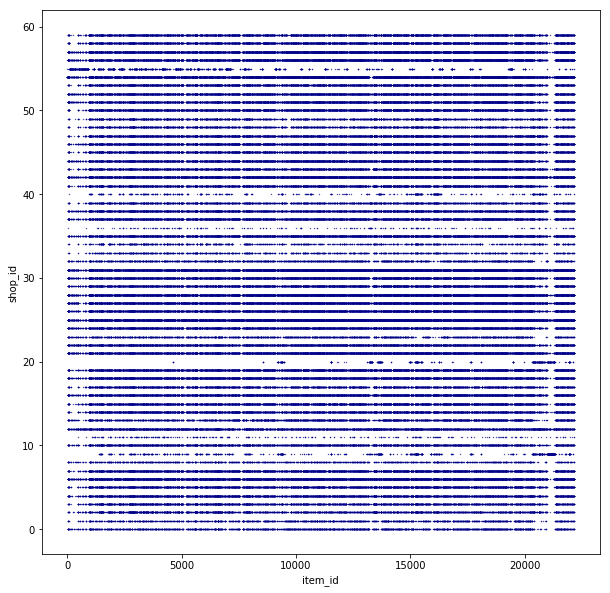

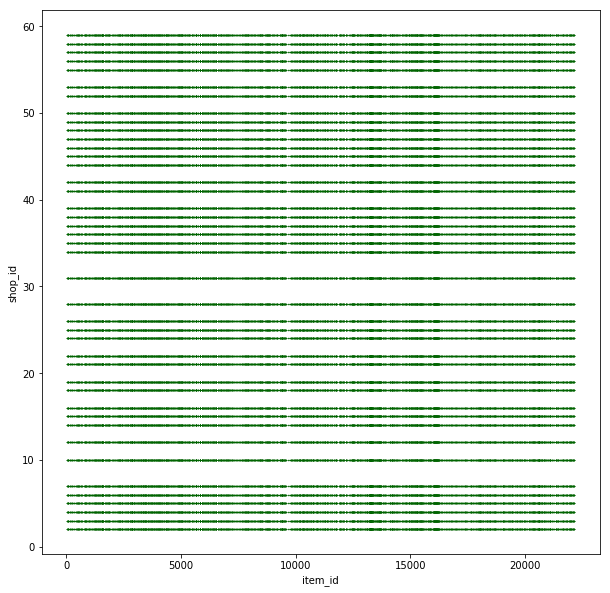

In [22]:
sales.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkBlue', s = 0.1,figsize = (10,10))
test.drop_duplicates(subset=['item_id', 'shop_id']).plot.scatter('item_id', 'shop_id', color='DarkGreen', s = 0.1,figsize = (10,10))



We can see that after merging sales data on test data, there is about 50% of missing values.

In [23]:
test.merge(sales, how='left', on=['shop_id', 'item_id']).isnull().sum()

test.shape[0]

ID                     0
shop_id                0
item_id                0
date              102796
date_block_num    102796
item_price        102796
item_cnt_day      102796
dtype: int64

214200

Identify outliers in sales data. We found that there are some high price sales such as Radmin 3: Reliable Remote Support Software which more than USD 3468 or 200000 Russian Ruble.

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
1163158,13.12.2013,11,12,6066,307980.0,1.0


,item_name,item_id,item_category_id
6066,Radmin 3 - 522 лиц.,6066,75


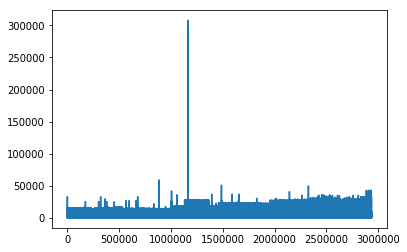

In [24]:
sales.item_price.plot()
sales[sales['item_price'] > 100000]
items[items['item_id'] == 6066]


For number of sales, there is an amount of sales more than 900. They are some kind of plastic bags and delivery services.

In [25]:
from IPython.display import display, HTML



,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
845690,18.09.2013,8,42,3732,2521.211982,217.0
862929,17.09.2013,8,25,3732,2545.135417,264.0
890790,17.09.2013,8,31,3732,2550.597222,288.0
1058340,22.11.2013,10,12,11373,102.466942,242.0
1170072,28.12.2013,11,15,20949,5.000000,255.0
1501160,15.03.2014,14,24,20949,5.000000,405.0
1549966,09.04.2014,15,54,20949,5.000000,300.0
1573252,23.04.2014,15,27,8057,1200.000000,401.0
1573253,22.04.2014,15,27,8057,1200.000000,502.0
1618930,23.04.2014,15,29,8057,1200.000000,240.0


3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
3732                             Grand Theft Auto V [PS3, русские субтитры]
11373                                  Доставка до пункта выдачи (Boxberry)
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
8057                                                       iTunes 1500 руб.
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
20949                 Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм
9242     Билет "ИгроМир 2014" (на один день (отдельно - 4, 5 октября 2014))
19437       

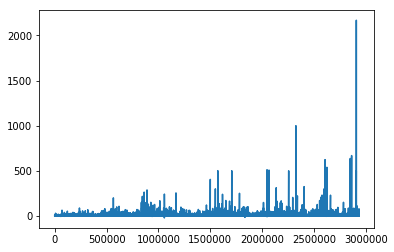

In [26]:
sales.item_cnt_day.plot()

popular_sales = sales[sales['item_cnt_day'] >200]
display(popular_sales)
pd.options.display.max_colwidth = 100
print(items.loc[popular_sales.item_id].item_name)

Outliers above are removed so we only include item price that less than 100000 and amount of sales that less or equal to 900.

In [27]:
sales = sales[sales.item_price<100000]
sales = sales[sales.item_cnt_day<=900]

# Aggregate data

Since the competition task is to make a monthly prediction, we need to aggregate the data to montly level before doing any encodings. The following code-cell serves just that purpose.

In [28]:
sales_m = sales.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': 'sum','item_price': np.mean}).reset_index()

sales_m = pd.merge(grid,sales_m, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

sales_m['date_block_month'] = np.mod(sales_m['date_block_num'],12)
sales_m = pd.merge(sales_m,shop          , on=['shop_id']          , how='left' )
sales_m = pd.merge(sales_m,items         , on=['item_id']          , how='left' )
sales_m = pd.merge(sales_m,item_category , on=['item_category_id'] , how='left' )

print('Drop all string columns, leave encoded only');
string_columns =[             'item_name',
                     'item_category_name',
                 'item_metacategory_name',
                              'shop_name',
                 'shop_city',
                 'shop_city_subj']
sales_m = sales_m.drop(columns=string_columns);

print('Convert numerical feature to int16')
sales_m.item_price = sales_m.item_price.astype('int16');


display(sales_m.sample(100))



Drop all string columns, leave encoded only
Convert numerical feature to int16


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id
9792258,35,7997,29,0.0,0,5,15,1250615,11,55,12
10257572,44,5486,31,0.0,0,7,19,1164900,15,58,12
6589290,35,8762,18,0.0,0,6,15,1250615,11,40,10
1490864,41,19108,3,0.0,0,3,18,1091544,14,40,10
1814312,18,6080,4,0.0,0,4,11,973826,7,23,5
10672141,27,16130,32,0.0,0,8,13,11514330,9,65,13
3127703,17,306,8,0.0,0,8,11,973826,7,45,11
10382014,19,19742,31,2.0,199,7,12,414595,8,40,10
2010534,15,2349,5,1.0,199,5,8,325185,5,30,8
8675804,56,19254,24,0.0,0,0,27,60677,10,28,8


# Mean encoding

We perform mean encoding on all category data which are item_id, shop_id and item_category_id

In [29]:
mean_enc_cols = []
for type_id in ['item_id','shop_id','item_category_id']:
    for column_id, agg_func, func_name in [ ('item_price',np.mean,'avg'),
                                           ('item_cnt_day',np.sum,'sum'),
                                           ('item_cnt_day',np.mean,'avg')]:

        col_name = type_id+'_'+func_name+'_'+column_id
        print('Mean econding %s....'%col_name)
        mean_enc_cols.append(col_name)  
        mean_df = sales_m.groupby([type_id,'date_block_num']).agg(agg_func).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [col_name , type_id, 'date_block_num']
        
        sales_m = pd.merge(sales_m,mean_df,on=['date_block_num', type_id],how='left')

Mean econding item_id_avg_item_price....
Mean econding item_id_sum_item_cnt_day....
Mean econding item_id_avg_item_cnt_day....
Mean econding shop_id_avg_item_price....
Mean econding shop_id_sum_item_cnt_day....
Mean econding shop_id_avg_item_cnt_day....
Mean econding item_category_id_avg_item_price....
Mean econding item_category_id_sum_item_cnt_day....
Mean econding item_category_id_avg_item_cnt_day....


In [30]:
display(sales_m.head(10))
display(sales_m.tail(10))

,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999,0,29,591486,22,37,10,310.800000,18.0,0.400000,97.969563,2017.0,0.248552,63.006981,6094.0,0.199738
1,59,2552,0,0.0,0,0,29,591486,22,58,12,19.977778,0.0,0.000000,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
2,59,2554,0,0.0,0,0,29,591486,22,58,12,37.977778,1.0,0.022222,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
3,59,2555,0,0.0,0,0,29,591486,22,56,12,48.822222,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
4,59,2564,0,0.0,0,0,29,591486,22,59,12,36.400000,5.0,0.111111,97.969563,2017.0,0.248552,35.593613,701.0,0.093280
5,59,2565,0,0.0,0,0,29,591486,22,56,12,24.400000,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
6,59,2572,0,0.0,0,0,29,591486,22,55,12,56.555556,12.0,0.266667,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
7,59,2573,0,0.0,0,0,29,591486,22,55,12,73.088889,16.0,0.355556,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
8,59,2574,0,2.0,399,0,29,591486,22,55,12,258.000000,119.0,2.644444,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
9,59,2593,0,0.0,0,0,29,591486,22,55,12,28.244444,5.0,0.111111,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
10913840,21,7610,33,0.0,0,9,13,11514330,9,64,13,65.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913841,21,7612,33,0.0,0,9,13,11514330,9,64,13,5.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913842,21,7615,33,0.0,0,9,13,11514330,9,64,13,5.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913843,21,7627,33,0.0,0,9,13,11514330,9,64,13,7.931818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913844,21,7628,33,0.0,0,9,13,11514330,9,64,13,5.681818,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913845,21,7635,33,0.0,0,9,13,11514330,9,64,13,47.727273,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913846,21,7638,33,0.0,0,9,13,11514330,9,64,13,42.954545,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913847,21,7640,33,0.0,0,9,13,11514330,9,64,13,91.818182,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913848,21,7632,33,0.0,0,9,13,11514330,9,64,13,52.500000,1.0,0.022727,186.033623,1912.0,0.353224,146.981926,870.0,0.155691
10913849,21,7440,33,0.0,0,9,13,11514330,9,57,12,6.795455,1.0,0.022727,186.033623,1912.0,0.353224,15.547865,364.0,0.062672


We append test data into train data so we can create lag features on them.

In [31]:
temp_test = test.copy()

TEST_DATE_BLOCK_ID = 34

temp_test['date_block_num'] = TEST_DATE_BLOCK_ID
temp_test['date_block_month'] = np.mod(temp_test['date_block_num'],12)

temp_test.drop('ID', axis=1, inplace=True)
temp_test = temp_test.merge(shop          , how='left' ,on=['shop_id'] )
temp_test = temp_test.merge(items         , how='left', on='item_id')
temp_test = temp_test.merge(item_category , how='left', on='item_category_id')


string_columns =[             'item_name',
                     'item_category_name',
                 'item_metacategory_name',
                              'shop_name',
                 'shop_city',
                 'shop_city_subj']

temp_test = temp_test.drop(columns=string_columns);




In [32]:
display(temp_test)

,shop_id,item_id,date_block_num,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id
0,5,5037,34,10,2,301642,3,19,5
1,5,5320,34,10,2,301642,3,55,12
2,5,5233,34,10,2,301642,3,19,5
3,5,5232,34,10,2,301642,3,23,5
4,5,5268,34,10,2,301642,3,20,5
5,5,5039,34,10,2,301642,3,23,5
6,5,5041,34,10,2,301642,3,20,5
7,5,5046,34,10,2,301642,3,55,12
8,5,5319,34,10,2,301642,3,55,12
9,5,5003,34,10,2,301642,3,20,5


In [33]:
sales_m = pd.concat([sales_m,temp_test], axis=0, ignore_index=True,sort=False)

In [34]:
display(sales_m.head(10))
display(sales_m.sample(10))
display(sales_m.tail(10))


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
0,59,22154,0,1.0,999.0,0,29,591486,22,37,10,310.800000,18.0,0.400000,97.969563,2017.0,0.248552,63.006981,6094.0,0.199738
1,59,2552,0,0.0,0.0,0,29,591486,22,58,12,19.977778,0.0,0.000000,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
2,59,2554,0,0.0,0.0,0,29,591486,22,58,12,37.977778,1.0,0.022222,97.969563,2017.0,0.248552,54.898413,287.0,0.043386
3,59,2555,0,0.0,0.0,0,29,591486,22,56,12,48.822222,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
4,59,2564,0,0.0,0.0,0,29,591486,22,59,12,36.400000,5.0,0.111111,97.969563,2017.0,0.248552,35.593613,701.0,0.093280
5,59,2565,0,0.0,0.0,0,29,591486,22,56,12,24.400000,2.0,0.044444,97.969563,2017.0,0.248552,38.266481,268.0,0.049630
6,59,2572,0,0.0,0.0,0,29,591486,22,55,12,56.555556,12.0,0.266667,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
7,59,2573,0,0.0,0.0,0,29,591486,22,55,12,73.088889,16.0,0.355556,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
8,59,2574,0,2.0,399.0,0,29,591486,22,55,12,258.000000,119.0,2.644444,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211
9,59,2593,0,0.0,0.0,0,29,591486,22,55,12,28.244444,5.0,0.111111,97.969563,2017.0,0.248552,39.401313,12527.0,0.208211


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
7736388,38,4264,21,0.0,0.0,9,17,1154000,13,31,8,5.750000,1.0,0.019231,116.449637,1315.0,0.207610,7.519931,3035.0,0.163488
7624869,35,13671,21,0.0,0.0,9,15,1250615,11,69,13,37.442308,6.0,0.115385,136.480107,1808.0,0.285444,154.979231,1423.0,0.364872
569307,3,7179,1,0.0,0.0,1,0,215353,10,56,12,10.847826,1.0,0.021739,46.057419,798.0,0.097698,38.938322,296.0,0.049882
8811049,38,18206,25,0.0,0.0,1,17,1154000,13,57,12,29.000000,5.0,0.106383,136.402115,1403.0,0.231786,18.765821,628.0,0.085652
5089611,46,16087,13,0.0,0.0,1,21,110878,10,65,13,8.673913,2.0,0.043478,122.658957,2367.0,0.331791,69.567158,2157.0,0.837345
9140439,58,14588,26,0.0,0.0,2,28,269486,21,37,10,8.652174,2.0,0.043478,174.426669,2359.0,0.387866,42.346325,5098.0,0.166406
5956496,3,21611,16,0.0,0.0,4,0,215353,10,37,10,8.122449,2.0,0.040816,62.440239,776.0,0.116081,41.266010,7177.0,0.157833
2834894,29,13027,7,0.0,0.0,7,13,11514330,9,55,12,42.244444,13.0,0.288889,83.632175,2073.0,0.258125,47.851535,14131.0,0.258242
10432311,28,802,31,0.0,0.0,7,13,11514330,9,49,11,5.952381,1.0,0.023810,273.676782,3749.0,0.733947,39.115363,571.0,0.161848
8471481,17,16160,24,0.0,0.0,0,11,973826,7,64,13,851.560000,32.0,0.640000,91.555465,689.0,0.112233,261.471134,2211.0,0.455876


,shop_id,item_id,date_block_num,item_cnt_day,item_price,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price,item_id_sum_item_cnt_day,item_id_avg_item_cnt_day,shop_id_avg_item_price,shop_id_sum_item_cnt_day,shop_id_avg_item_cnt_day,item_category_id_avg_item_price,item_category_id_sum_item_cnt_day,item_category_id_avg_item_cnt_day
11128040,45,3280,34,NaN,NaN,10,19,1164900,15,55,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128041,45,4393,34,NaN,NaN,10,19,1164900,15,22,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128042,45,4352,34,NaN,NaN,10,19,1164900,15,22,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128043,45,18049,34,NaN,NaN,10,19,1164900,15,70,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128044,45,18027,34,NaN,NaN,10,19,1164900,15,70,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128045,45,18454,34,NaN,NaN,10,19,1164900,15,55,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128046,45,16188,34,NaN,NaN,10,19,1164900,15,64,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128047,45,15757,34,NaN,NaN,10,19,1164900,15,55,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128048,45,19648,34,NaN,NaN,10,19,1164900,15,40,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11128049,45,969,34,NaN,NaN,10,19,1164900,15,37,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We create lags on 10 features. 9 features are from mean encoding and 1 feature is the item_cnt_day.

After several tries, we found that month lag intervals of 1, 2, 3, 4, 5, 6, 9 and 12 give best score in the leaderboard. Take note that 16GB of ram is unable to compute such large number of interval. We need at least 64GB of ram. 

In [35]:
lag_variables = mean_enc_cols + ['item_cnt_day'] 
print('\n'.join(lag_variables))

#Limited by computation resource

#lags = [1,2]
lags = [1, 2, 3, 4, 6, 12]

for lag in lags:
    print('In progress %2d ...'% lag)
    sales_new_df = sales_m.copy()
    sales_new_df.date_block_num+=lag
    sales_new_df = sales_new_df[['date_block_num','shop_id','item_id']+lag_variables]
    
    sales_new_df.columns = ['date_block_num','shop_id','item_id']+ [lag_feat+'_lag_'+str(lag) for lag_feat in lag_variables]
    
    sales_m = sales_m.merge(sales_new_df,on=['date_block_num','shop_id','item_id'] ,how='left')
print('Features created!')

print('Save them...')
raw_sales_file = 'raw_sales_m.pickle'
sales_m.to_pickle(raw_sales_file)
print('Features saved %s' % raw_sales_file)

item_id_avg_item_price
item_id_sum_item_cnt_day
item_id_avg_item_cnt_day
shop_id_avg_item_price
shop_id_sum_item_cnt_day
shop_id_avg_item_cnt_day
item_category_id_avg_item_price
item_category_id_sum_item_cnt_day
item_category_id_avg_item_cnt_day
item_cnt_day
In progress  1 ...
In progress  2 ...
In progress  3 ...
In progress  4 ...
In progress  6 ...
In progress 12 ...
Features created!
Save them...
Features saved raw_sales_m.pickle


Fill missing values


<div class="panel panel-warning">

NaN filled with median and zeros for XGBoost

<div class="panel-body">

Catboost can work with NaN

</div>

</div>

In [36]:
for feat in sales_m.columns:
    if 'item_cnt' in feat:
        sales_m[feat]=sales_m[feat].fillna(0)
    elif 'item_price' in feat:
        sales_m[feat]=sales_m[feat].fillna(sales_m[feat].median())

Drop uneccesary columns and take data only after 12 since the most lag month interval is 12.

In [37]:
sales_m = sales_m[sales_m['date_block_num']>12]

# Train/Test/Validation split

We use holdout scheme for cross validation. We use sales month from 12 to 32 for training, month 33 for validation and month 34 for testing. 

In [38]:
cols_to_drop = lag_variables[:-1] + ['item_price']

print(cols_to_drop)

sales_train = sales_m[sales_m['date_block_num'] <  TEST_DATE_BLOCK_ID-1 ].drop(cols_to_drop, axis=1)
sales_cv    = sales_m[sales_m['date_block_num'] == TEST_DATE_BLOCK_ID-1 ].drop(cols_to_drop, axis=1)
sales_test  = sales_m[sales_m['date_block_num'] == TEST_DATE_BLOCK_ID   ].drop(cols_to_drop, axis=1)


sales_train.to_pickle('sales_train.pickle')
sales_cv.to_pickle('sales_train.pickle')
sales_test.to_pickle('sales_train.pickle')



['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [39]:
print( 'Train '+ f"{len(sales_train):,d}")
print( 'Valid '+ f"{len(sales_cv):,d}")
print( 'Test  '+ f"{len(sales_test):,d}")

Train 5,839,576
Valid 238,172
Test  214,200


# Reference from discussion

From discussion in Kaggle forum, we applied this useful trick, which clip the item_cnt_day within 40 instead of 20. In this way, there are more predictions on item_cnt_day = 20.

In [40]:
sales_train['item_cnt_day'].clip_upper(40, inplace=True)
sales_train['item_cnt_day'].clip_lower(0, inplace=True)

sales_cv['item_cnt_day'].clip_upper(40, inplace=True)
sales_cv['item_cnt_day'].clip_lower(0, inplace=True)

sales_test['item_cnt_day'].clip_upper(40, inplace=True)
sales_test['item_cnt_day'].clip_lower(0, inplace=True)

# XGBooost

In [41]:
import xgboost as xgb

## Training

In [42]:
drop_cols = [ 'date_block_num',
             'item_cnt_day',
             'item_category_name',
             'item_metacategory_name', 
             'shop_city', 
             'shop_city_subj',
             'shop_name'            
            ]
x_cols = [c for c in sales_train.columns if c not in drop_cols]

X_train = sales_train[x_cols]
y_train = sales_train['item_cnt_day']

X_val   = sales_cv[x_cols]
y_val   = sales_cv['item_cnt_day']



In [43]:
params = {
        'eta'         : 0.08, #best 0.08
        'max_depth'   : 7,
        'objective'   : 'reg:linear',
        'eval_metric' : 'rmse',
        'seed'        : 3,
        'gamma'       : 1,
        'silent'      : True
    }
watchlist = [(xgb.DMatrix(X_train, y_train), 'train'),
             (xgb.DMatrix(X_val, y_val), 'valid')]


xgb_model = xgb.train( params, 
                   xgb.DMatrix(X_train, y_train), 
                   3500,  
                   watchlist, 
                   maximize=False, 
                   verbose_eval=10, 
                   early_stopping_rounds=50 )

[17:37:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.40499	valid-rmse:1.37875
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.14753	valid-rmse:1.1979
[20]	train-rmse:1.07149	valid-rmse:1.15302
[30]	train-rmse:1.0435	valid-rmse:1.14307
[40]	train-rmse:1.02674	valid-rmse:1.13878
[50]	train-rmse:1.01649	valid-rmse:1.13785
[60]	train-rmse:1.00639	valid-rmse:1.13433
[70]	train-rmse:0.996556	valid-rmse:1.13327
[80]	train-rmse:0.986761	valid-rmse:1.13119
[90]	train-rmse:0.979707	valid-rmse:1.13241
[100]	train-rmse:0.973253	valid-rmse:1.13531
[110]	train-rmse:0.968715	valid-rmse:1.13315
[120]	train-rmse:0.962651	valid-rmse:1.13881
[130]	train-rmse:0.956881	valid-rmse:1.13542
Stopping. Best iteration:
[81]	train-rmse:0.986251	valid-rmse:1.13036



## Prediction

In [44]:
import pickle

In [92]:
pickle.dump(model, open("xgb_095754_ver3.pickle.dat", "wb"))
#model = pickle.load(open("pima.pickle.dat", "rb"))

xgb_pred = model.predict(xgb.DMatrix(sales_test[x_cols]), ntree_limit=model.best_ntree_limit)

xgb_sugmission = pd.DataFrame({ 
            'ID'            : test.ID,
            'item_cnt_month': xgb_pred.clip(0,20)
} );


xgb_sugmission.to_csv('xgb_sugmission.csv', index=False)
xgb_sugmission.sample(30)
print('Done!')


,ID,item_cnt_month
48664,48664,0.958683
114861,114861,0.050635
122131,122131,0.238467
11457,11457,0.158860
33880,33880,0.000000
75440,75440,0.270933
73678,73678,0.073723
184096,184096,0.144456
97820,97820,0.203865
202529,202529,0.134929


Done!


Submission without leakage features, limited lag to 2
 
Leader board result 1.00240, 1738/4000


```
[0]	train-rmse:1.40963	valid-rmse:1.37883
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:1.06173	valid-rmse:1.16237
[100]	train-rmse:1.03781	valid-rmse:1.16024
[150]	train-rmse:1.02113	valid-rmse:1.1565
[200]	train-rmse:1.00696	valid-rmse:1.15566
Stopping. Best iteration:
[178]	train-rmse:1.01212	valid-rmse:1.15087
```

With Leagake Features
```
[17:37:30] Tree method is automatically selected to be 'approx' for faster speed. to use old behavior(exact greedy algorithm on single machine), set tree_method to 'exact'
[0]	train-rmse:1.40499	valid-rmse:1.37875
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[10]	train-rmse:1.14753	valid-rmse:1.1979
[20]	train-rmse:1.07149	valid-rmse:1.15302
[30]	train-rmse:1.0435	valid-rmse:1.14307
[40]	train-rmse:1.02674	valid-rmse:1.13878
[50]	train-rmse:1.01649	valid-rmse:1.13785
[60]	train-rmse:1.00639	valid-rmse:1.13433
[70]	train-rmse:0.996556	valid-rmse:1.13327
[80]	train-rmse:0.986761	valid-rmse:1.13119
[90]	train-rmse:0.979707	valid-rmse:1.13241
[100]	train-rmse:0.973253	valid-rmse:1.13531
[110]	train-rmse:0.968715	valid-rmse:1.13315
[120]	train-rmse:0.962651	valid-rmse:1.13881
[130]	train-rmse:0.956881	valid-rmse:1.13542
Stopping. Best iteration:
[81]	train-rmse:0.986251	valid-rmse:1.13036
```

# CatBoost

In [87]:
y_train.sample(5)

5600176    0.0
9197645    0.0
9855689    0.0
8830848    0.0
9166362    2.0
Name: item_cnt_day, dtype: float64

In [47]:
print(model_with_early_stop.best_iteration_)

NameError: name 'model_with_early_stop' is not defined

In [61]:
X_train.colu

,shop_id,item_id,date_block_month,shop_city_id,shop_city_pop,shop_city_subj_id,item_category_id,item_metacategory_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,...,item_id_avg_item_price_lag_12,item_id_sum_item_cnt_day_lag_12,item_id_avg_item_cnt_day_lag_12,shop_id_avg_item_price_lag_12,shop_id_sum_item_cnt_day_lag_12,shop_id_avg_item_cnt_day_lag_12,item_category_id_avg_item_price_lag_12,item_category_id_sum_item_cnt_day_lag_12,item_category_id_avg_item_cnt_day_lag_12,item_cnt_day_lag_12
4836102,27,15242,1,13,11514330,9,63,13,131.152174,9.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836103,27,15200,1,13,11514330,9,69,13,10.847826,1.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836104,27,15279,1,13,11514330,9,63,13,399.195652,48.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836105,27,15202,1,13,11514330,9,69,13,10.847826,2.0,...,54.239130,5.0,0.108696,157.859207,4546.0,0.556562,94.918715,503.0,0.237713,0.0
4836106,27,14888,1,13,11514330,9,55,12,214.826087,21.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836107,27,14890,1,13,11514330,9,58,12,47.782609,2.0,...,95.565217,5.0,0.108696,157.859207,4546.0,0.556562,63.926087,333.0,0.048261,0.0
4836108,27,14912,1,13,11514330,9,40,10,355.434783,404.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836109,27,14913,1,13,11514330,9,37,10,402.282609,38.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836110,27,15227,1,13,11514330,9,63,13,782.260870,27.0,...,45.869565,0.0,0.000000,97.232909,0.0,0.000000,44.714377,0.0,0.000000,0.0
4836111,27,14925,1,13,11514330,9,41,10,78.717391,4.0,...,357.586957,14.0,0.304348,157.859207,4546.0,0.556562,157.200412,1670.0,0.214819,1.0


In [69]:
from catboost import CatBoostRegressor

cat_features = [
 'shop_id'
,'item_id'
,'date_block_month'
,'shop_city_id'
,'shop_city_pop'
,'shop_city_subj_id'
,'item_category_id'
,'item_metacategory_id'
]


print("Train CatBoost Decision Tree")
cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.01,
                             depth=7,
                             eval_metric='RMSE',
                             random_seed = 23,
                             metric_period = 25,
                             task_type = "GPU"
                             )
cb_model.fit(X_train, y_train,
             eval_set=(X_val,y_val),
             cat_features=cat_features,
             use_best_model=True,
             verbose=True)



Train CatBoost Decision Tree
0:	learn: 1.4635339	test: 1.4193590	best: 1.4193590 (0)	total: 1.17s	remaining: 13m 36s
25:	learn: 1.3187733	test: 1.3354389	best: 1.3354389 (25)	total: 32.3s	remaining: 13m 57s
50:	learn: 1.2150227	test: 1.2840972	best: 1.2840972 (50)	total: 1m 5s	remaining: 13m 48s
75:	learn: 1.1403543	test: 1.2524410	best: 1.2524410 (75)	total: 1m 37s	remaining: 13m 22s
100:	learn: 1.0866839	test: 1.2355350	best: 1.2355350 (100)	total: 2m 10s	remaining: 12m 56s
125:	learn: 1.0480555	test: 1.2270685	best: 1.2270685 (125)	total: 2m 43s	remaining: 12m 25s
150:	learn: 1.0197376	test: 1.2223887	best: 1.2223887 (150)	total: 3m 16s	remaining: 11m 53s
175:	learn: 0.9984333	test: 1.2205820	best: 1.2205820 (175)	total: 3m 48s	remaining: 11m 21s
200:	learn: 0.9814475	test: 1.2181119	best: 1.2181119 (200)	total: 4m 22s	remaining: 10m 51s
225:	learn: 0.9685955	test: 1.2178486	best: 1.2178486 (225)	total: 4m 54s	remaining: 10m 18s
250:	learn: 0.9568849	test: 1.2202917	best: 1.2178486 

```

cb_model = CatBoostRegressor(iterations=700,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='RMSE',
                             random_seed = 23,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 75,
                             task_type = "GPU",
                             od_wait=100)
                             
Train CatBoost Decision Tree
0:	learn: 1.4550890	test: 1.4151798	best: 1.4151798 (0)	total: 2.27s	remaining: 26m 26s
75:	learn: 0.9496144	test: 1.2138983	best: 1.2138983 (75)	total: 2m 37s	remaining: 21m 30s
150:	learn: 0.8609199	test: 1.2060701	best: 1.2058770 (149)	total: 5m 11s	remaining: 18m 54s
225:	learn: 0.8285470	test: 1.1976246	best: 1.1968117 (210)	total: 7m 41s	remaining: 16m 7s
300:	learn: 0.8082756	test: 1.1945270	best: 1.1945270 (300)	total: 10m 6s	remaining: 13m 23s
375:	learn: 0.7902871	test: 1.1959186	best: 1.1934450 (315)	total: 12m 35s	remaining: 10m 50s
bestTest = 1.193445014
bestIteration = 315
Shrink model to first 316 iterations.

```

# LightGBM

In [70]:
import lightgbm as lgb

In [85]:
# create dataset for lightgbm

cat_features = [
 'shop_id'
,'item_id'
,'date_block_month'
,'shop_city_id'
,'shop_city_pop'
,'shop_city_subj_id'
,'item_category_id'
,'item_metacategory_id'
]
#categorical_feature=cat_features
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)

# specify your configurations as a dict
params = {
    'boosting_type'    : 'gbdt',
    'objective'        : 'regression',
    'metric'           : 'RMSE',
    'learning_rate'    : 0.02,
    'bagging_fraction' : 0.8,
    'bagging_freq'     : 5,
    'verbose'          : 20,
    'max_bin'          : 255,
}
#    

print('Starting training...')
# train
gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round       = 2000,
            valid_sets            = lgb_eval,
            early_stopping_rounds = 100,
    )
#             categorical_feature   = cat_features

Starting training...
[1]	valid_0's rmse: 1.38807
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's rmse: 1.37859
[3]	valid_0's rmse: 1.36916
[4]	valid_0's rmse: 1.36021
[5]	valid_0's rmse: 1.35158
[6]	valid_0's rmse: 1.34322
[7]	valid_0's rmse: 1.33534
[8]	valid_0's rmse: 1.32752
[9]	valid_0's rmse: 1.32006
[10]	valid_0's rmse: 1.31302
[11]	valid_0's rmse: 1.306
[12]	valid_0's rmse: 1.29931
[13]	valid_0's rmse: 1.29331
[14]	valid_0's rmse: 1.28709
[15]	valid_0's rmse: 1.2811
[16]	valid_0's rmse: 1.27557
[17]	valid_0's rmse: 1.27007
[18]	valid_0's rmse: 1.26484
[19]	valid_0's rmse: 1.25983
[20]	valid_0's rmse: 1.25498
[21]	valid_0's rmse: 1.2509
[22]	valid_0's rmse: 1.2465
[23]	valid_0's rmse: 1.24236
[24]	valid_0's rmse: 1.23866
[25]	valid_0's rmse: 1.23483
[26]	valid_0's rmse: 1.23099
[27]	valid_0's rmse: 1.22736
[28]	valid_0's rmse: 1.22375
[29]	valid_0's rmse: 1.22057
[30]	valid_0's rmse: 1.21716
[31]	valid_0's rmse: 1.21384
[32]	valid_0's rmse: 1.2107
[33

[275]	valid_0's rmse: 1.12908
[276]	valid_0's rmse: 1.12904
[277]	valid_0's rmse: 1.12901
[278]	valid_0's rmse: 1.12899
[279]	valid_0's rmse: 1.12895
[280]	valid_0's rmse: 1.12926
[281]	valid_0's rmse: 1.12922
[282]	valid_0's rmse: 1.12927
[283]	valid_0's rmse: 1.1292
[284]	valid_0's rmse: 1.12915
[285]	valid_0's rmse: 1.12901
[286]	valid_0's rmse: 1.12901
[287]	valid_0's rmse: 1.1289
[288]	valid_0's rmse: 1.1289
[289]	valid_0's rmse: 1.12893
[290]	valid_0's rmse: 1.12882
[291]	valid_0's rmse: 1.1288
[292]	valid_0's rmse: 1.12875
[293]	valid_0's rmse: 1.12874
[294]	valid_0's rmse: 1.12874
[295]	valid_0's rmse: 1.12874
[296]	valid_0's rmse: 1.12844
[297]	valid_0's rmse: 1.12844
[298]	valid_0's rmse: 1.12847
[299]	valid_0's rmse: 1.12836
[300]	valid_0's rmse: 1.12833
[301]	valid_0's rmse: 1.12831
[302]	valid_0's rmse: 1.12824
[303]	valid_0's rmse: 1.12823
[304]	valid_0's rmse: 1.1282
[305]	valid_0's rmse: 1.12797
[306]	valid_0's rmse: 1.12798
[307]	valid_0's rmse: 1.12797
[308]	valid_0's

In [86]:
pickle.dump(gbm, open("gbm_best.pkl", "wb"))

In [ ]:
gbm.best_iteration

In [90]:
gbm_pred = gbm.predict(sales_test[x_cols])

gbm_submission = pd.DataFrame({ 
            'ID'            : test.ID,
            'item_cnt_month': gbm_pred.clip(0,20)
} );


gbm_submission.to_csv('gbm_submission.csv', index=False)
gbm_submission.sample(30)
print('Done!')


,ID,item_cnt_month
144152,144152,0.041514
60300,60300,0.293250
98932,98932,0.111407
173624,173624,1.562976
179449,179449,0.262545
96960,96960,3.965426
132371,132371,0.031963
166481,166481,0.107930
66145,66145,0.081579
90983,90983,0.027927


Done!
